# A short user guide to python tools for visualization and analysis of interferometric data

* ```BaseInterferometry```class is the base class that provides functionality  for analysis of interferometric data.
* Current analysis tools:
    - Fourier transform
    - Wigner-Ville transform
* ```Interferogram``` class is for experimental interferograms.
* ```Simulation``` class is for simulated interferograms.
* Simulations include:
    - Pulse profile
    - Interferogram itself



In [279]:
#import packages
import sys
import glob, os
from parse import parse

# set source path
codepath = os.path.abspath("/Users/Pavel/Documents/repos/Interferometry")
if codepath not in sys.path:
    sys.path.append(codepath)

#automatically track changes in the source code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Experimental interferograms

In [280]:
from Interferometry.classes.interferogram import Interferogram

## Work with a specific dataset in the current directory

## Read and display experimental data

* Initialize an instance of the class by providing all relevant arguments to ```ifgm = Interferogram()```

    * Provide the datapath to a directory of interest
    * Provide the filename to read
    * Set the units of time  and the time step used whilst recording the data


* Read 1D interferometric data by calling the ```read_data()``` method with empty arguments on the instance of the initialized class.              
        
        
* Display the dataset by calling the ```display_temporal_and_ft()```module on the instance of the class. This will automatically compute the 1D Fourier transform of the dataset and display it.

    * Specify the relevant arguments such as the wavelength range to display and the units. 
    * By setting ```vs_wavelength = True ```  one sets the Fourier data to be displayed as a function of wavelength instead of frequency
    * To plot only temporal data, set ```plot_type = temporal```
    * For details see ```help(ifgm.display_temporal_and_ft)```

In [281]:
cd "/Users/Pavel/Documents/repos/Interferometry/Interferometry/data/"

/Users/Pavel/Documents/repos/Interferometry/Interferometry/data


In [282]:
ls

20211014scan006-10650fs-to-10450fs-step-0.15fs-power-65.0uw-1exp-intrange-1300ns-bias-45v-volt-1k.txt*
20211014scan007-10650fs-to-10450fs-step-0.15fs-power-65.0uw-1exp-intrange-2600ns-bias-45v-volt-1k.txt*
20211014scan008-10650fs-to-10450fs-step-0.15fs-power-65.0uw-1exp-intrange-6500ns-bias-45v-volt-1k.txt*
20211014scan012-10650fs-to-10450fs-step-0.15fs-power-65.0uw-1exp-intrange-13000ns-bias-45v-volt-1k.txt*


In [283]:
datapath = os.path.abspath("/Users/Pavel/Documents/repos/Interferometry/Interferometry/data/")
filename = "20211014scan012-10650fs-to-10450fs-step-0.15fs-power-65.0uw-1exp-intrange-13000ns-bias-45v-volt-1k.txt"

ifgm = Interferogram(pathtodata = datapath, 
                     filetoread = filename, 
                     tau_units = "fs", 
                     tau_step = 0.15)
ifgm.read_data()


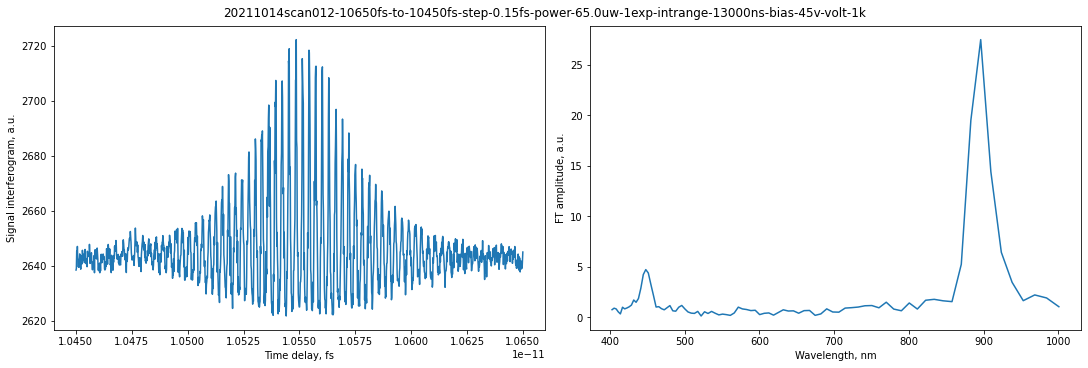

In [284]:
ifgm.display_temporal_and_ft(vs_wavelength=True, 
                             plot_type="both", 
                             wav_min=400, 
                             wav_max=1000, 
                             wav_units="nm")

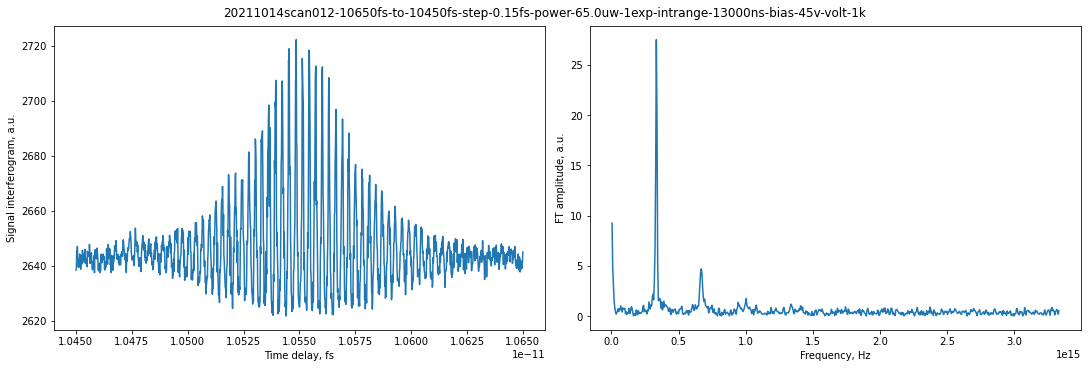

In [285]:
ifgm.display_temporal_and_ft(vs_wavelength=False, 
                             plot_type="both", 
                             wav_min=400, 
                             wav_max=800, 
                             wav_units="nm")

## Time-frequency analysis

### Normalization

Calling, ```display_temporal_and_ft```method, computes the Fourier transform of the whole signal. 
To determine local spectral characteritics of the signal as it changes over time, there are two options for time-frequency analysis:

* Short time Fourier transform (STFT) - commonly known as a spectrogram
* Wigner-Ville distribution (WVD)

Local spectral characteristics are important, or example, to analyse  the contributions of different harmonics as the signal changes over time.

Prior to application of these methods the data are normalised so that the signal values go from 0 to 8 and the baseline oscillations happen at 1.

* In ```normalizing_width```, set the temporal width of the sampled waveform to use for normalization and the position where it starts.

In [286]:
ifgm.normalize_interferogram(normalizing_width=10e-15, t_norm_start=10550e-15)

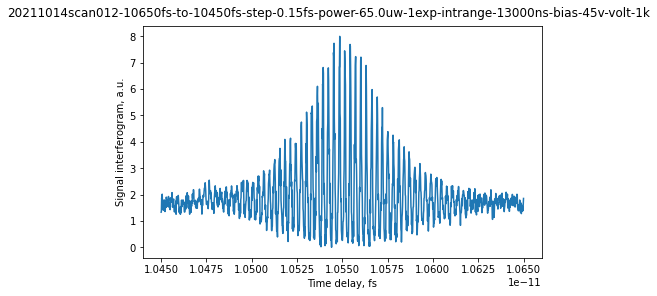

In [287]:
ifgm.display_temporal_and_ft(vs_wavelength=False, 
                             plot_type="temporal", 
                             wav_min=400, 
                             wav_max=1000, 
                             wav_units="nm")

### Spectrogram

* To compute the spectrogram, call ```compute_spectrogram_of_interferogram```method on the intererogram's class instance.
* ```nperse```sets the window size of the short time Fourier transform

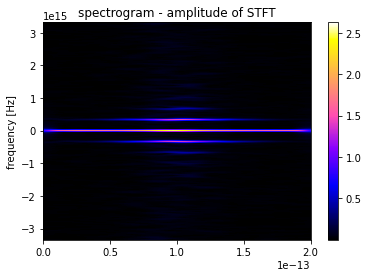

In [288]:
ifgm.compute_spectrogram_of_interferogram(nperseg=2**8,  plotting=True)

### Wigner-Ville transform

* WVT allows to obtain a better temporal resolution than STFT
* Call ```compute_wigner_ville_distribution```method on the intererogram's class instance and specify the parameters. One may need to vary the max and min hue values to avoid clipping.

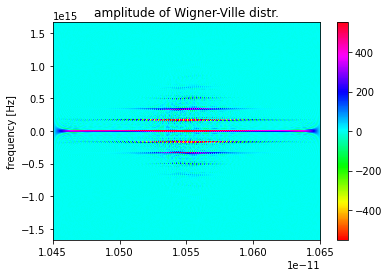

In [289]:
ifgm.compute_wigner_ville_distribution(ifgm.tau_samples, ifgm.interferogram, plotting=True, vmin=-550, vmax=550)

## Second-order correlation

* This needs further work 
- filter cutoff, filter order 

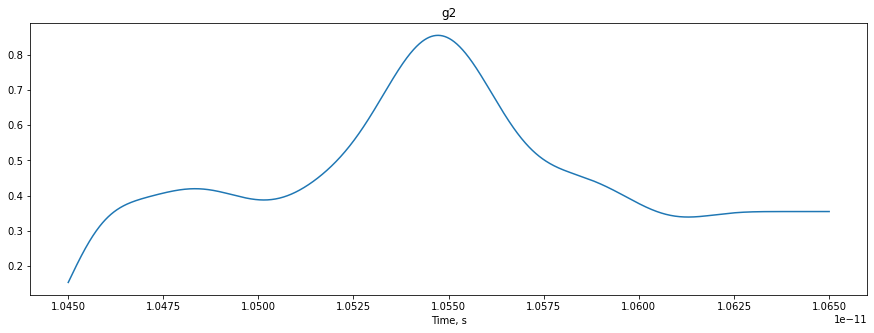

In [290]:
ifgm.gen_g2(filter_cutoff=35e12, filter_order=6, plotting=True)

In [259]:
order_min = 1
order_max = 5
order_step = 1

np.linspace(order_min, order_max, int(abs((order_max - order_min))/order_step)+1)

array([1., 2., 3., 4., 5.])

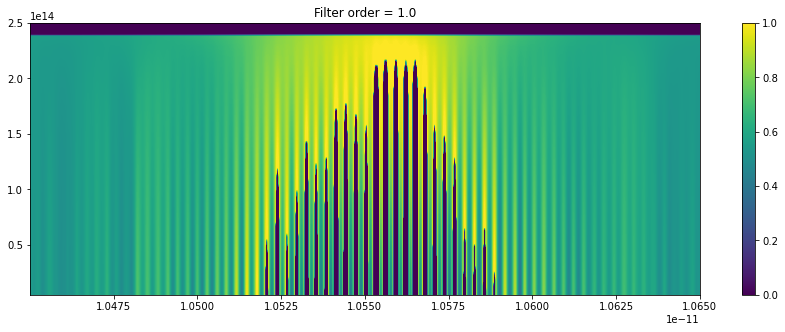

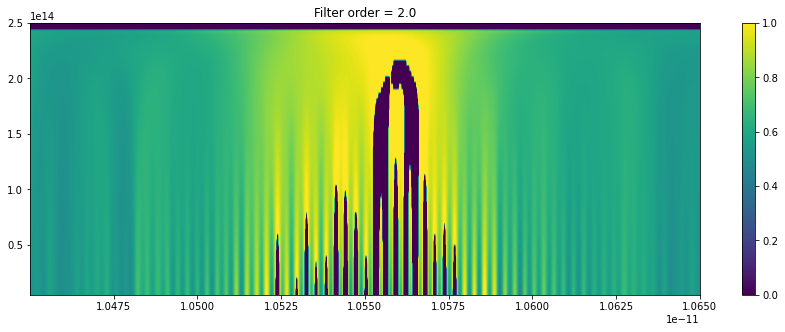

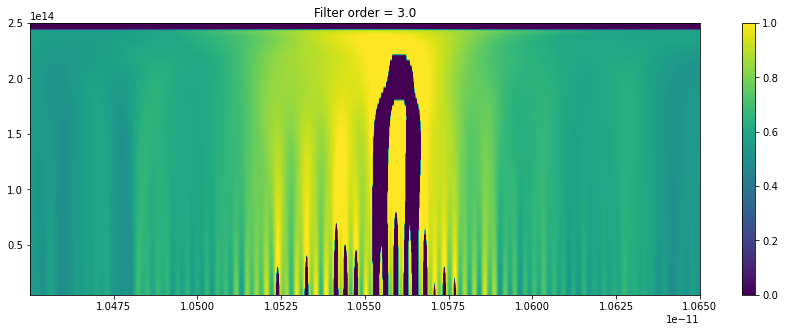

In [263]:
ifgm.gen_g2_vs_cutoff_freq(cutoff_min = 5e12, cutoff_max = 50 * 5e12, cutoff_step = 5e12,
                              order_min = 1, order_max = 3, order_step = 1,
                              g2_min = 0.95, g2_max = 1.05,
                              to_plot = True)

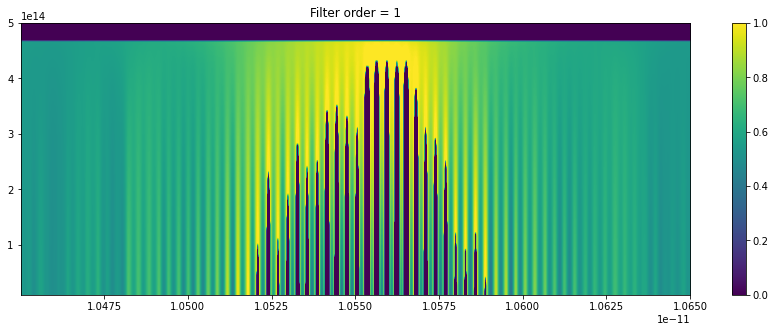

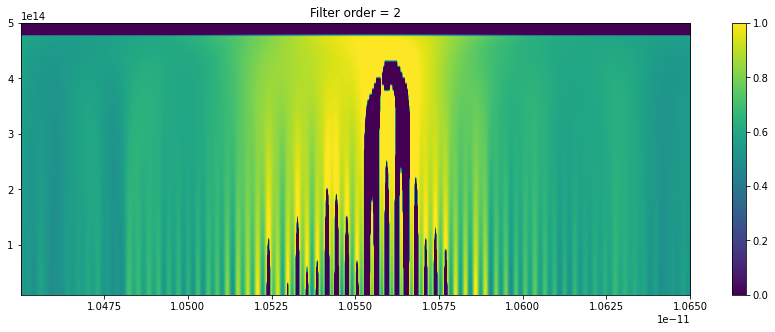

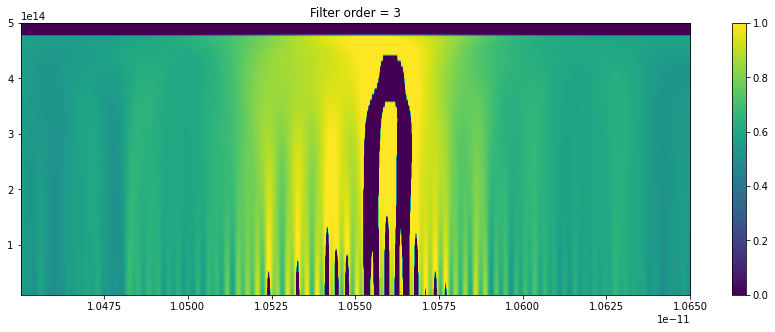

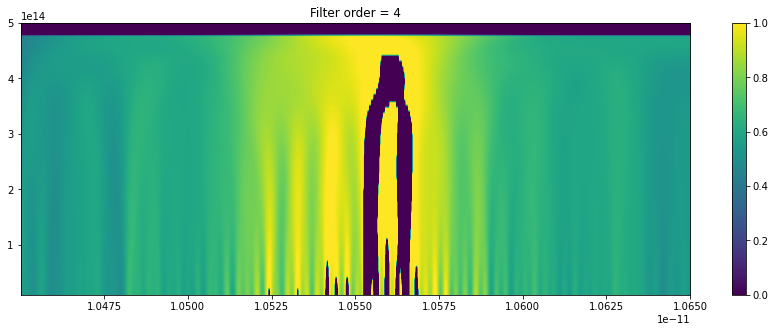

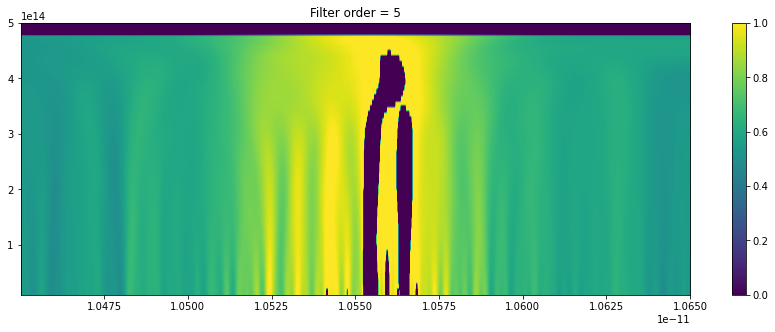

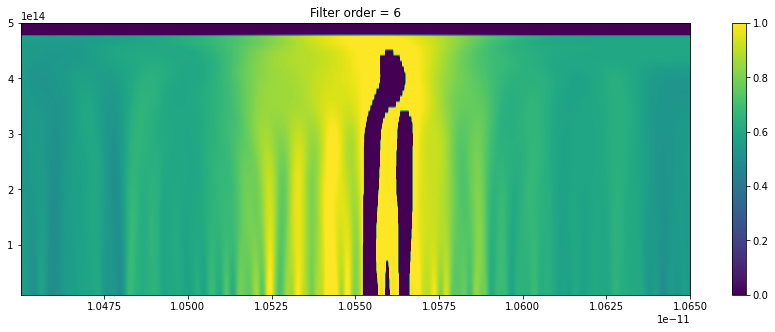

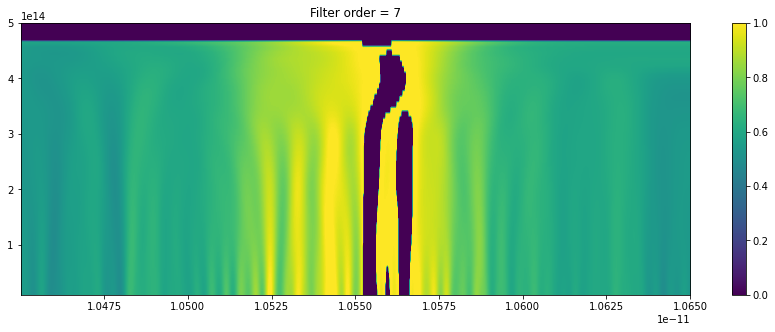

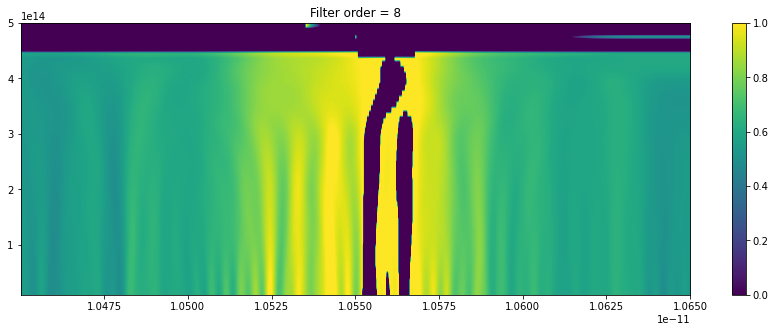

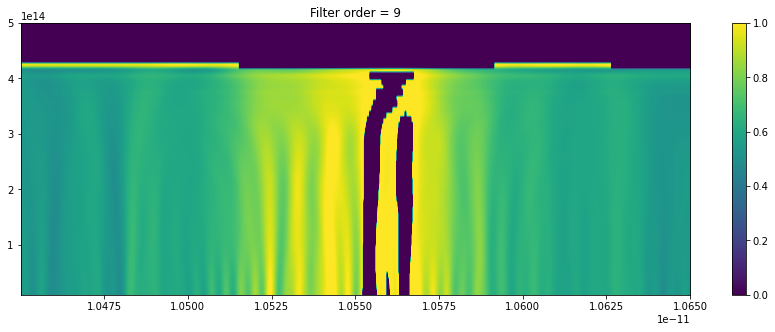

In [262]:
for fo in range(1,10,1):
    g2_survey = []

    for fc in range(1,50,1):
        fc = 5e12 * fc
        #print(fc)
        #
        ifgm.gen_g2(filter_cutoff=fc, filter_order=fo, plotting=False)
        ifgm.g2[ifgm.g2.max()<0.999]=-1
        g2_survey.append(ifgm.g2)
        #
    g2_survey = np.array(g2_survey)
    g2_survey[g2_survey>1.05]=-1
    #
    fig, ax = plt.subplots(1, figsize=(15, 5))
    plt.imshow(g2_survey, aspect='auto',
               cmap = plt.get_cmap("viridis"), vmin=0, vmax=1,
                  extent=(ifgm.tau_samples.min(), ifgm.tau_samples.max(),
                          fc_0 * fc_min, fc_0 * fc_max))
    plt.title("Filter order = {}".format(fo))
    plt.colorbar()
    plt.show()

    

## Display all data in any directory

You can also read, analyse and display all data in any directory of interest. It is assumed though that **all data were recorded using the same units of time** (e.g. all datasets have units of e.g. fs)

* Initialize an instance of the class by providing the relevant arguments to ```ifgm = Interferogram()```

    * Provide the datapath to a directory of interest
    * Set the unit of time used whilst recording the data
    * DO NOT set the ```filetoread``` and the ```time_step``` arguments - the code will find them out automatically whilst reading out the data sets.

* Read, analyse and display the dataset by calling the ```display_all()``` module on the instance of the initialized class using the same arguments as with the ```display()``` module.


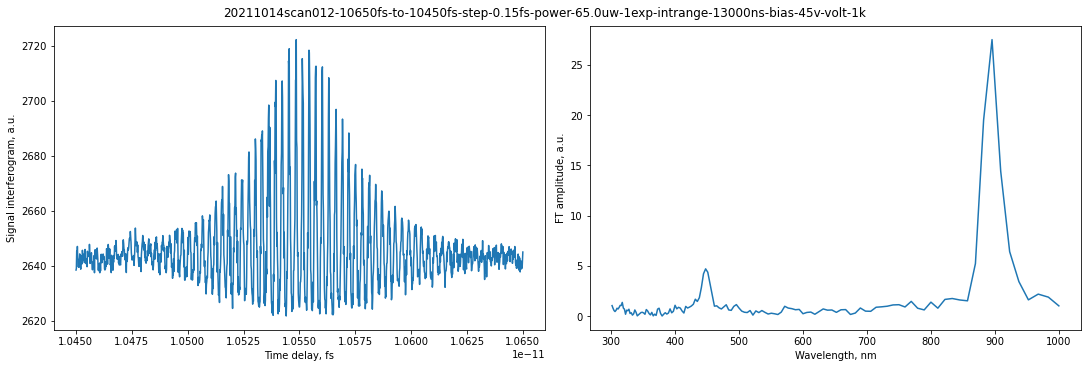

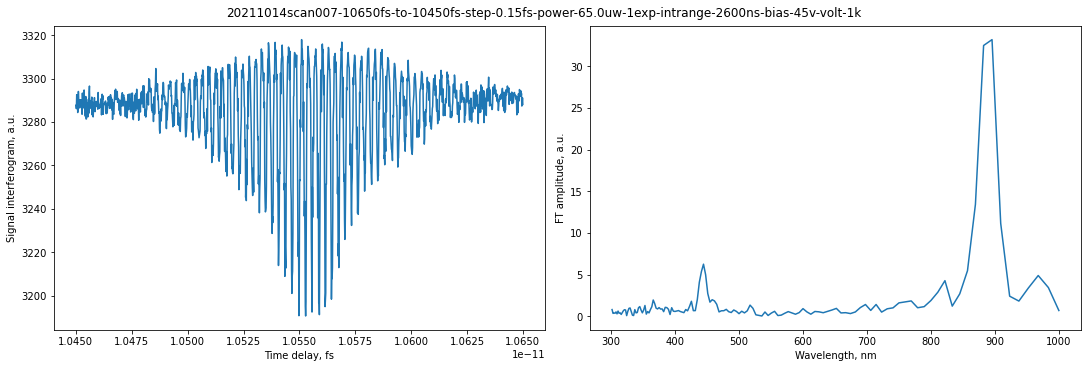

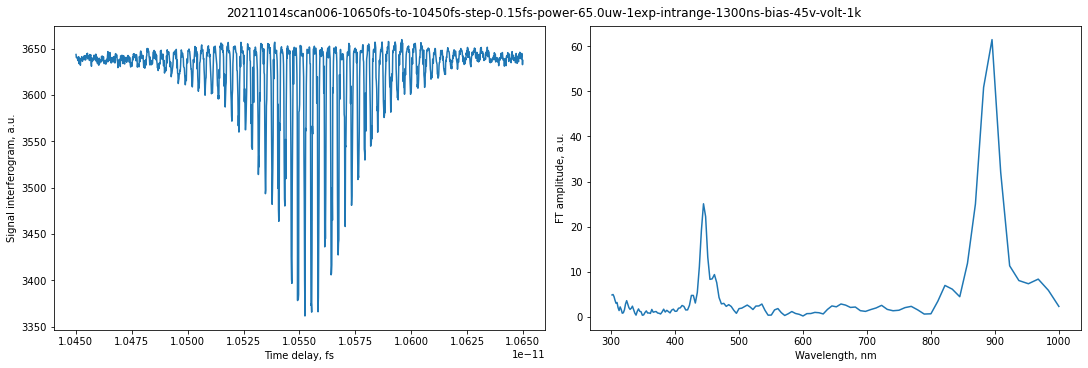

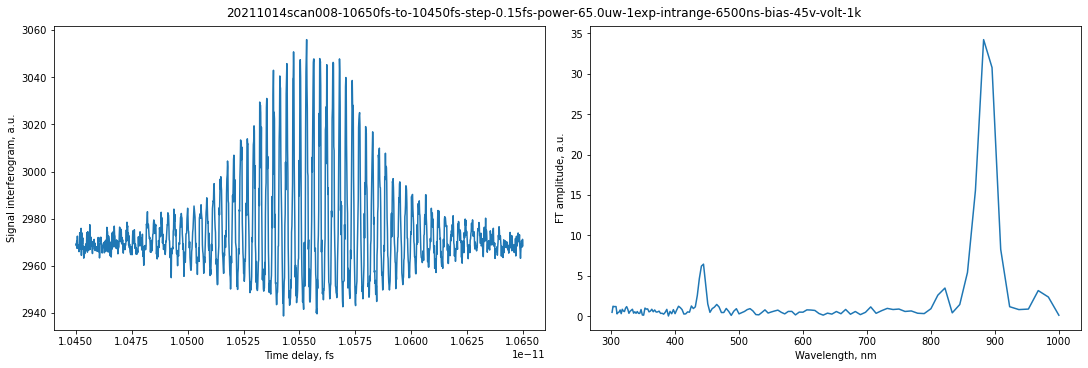

In [48]:
datapath = os.path.abspath("/Users/Pavel/Documents/repos/Interferometry/Interferometry/data/")

ifgm = Interferogram(pathtodata = datapath, tau_units = "fs")

ifgm.display_all(vs_wavelength=True, wav_min=300, wav_max=1000, wav_units="nm")

# Simulated interferograms 

## Field and interferogram distributions

In [127]:
from Interferometry.classes.simulation import Simulation

In [128]:
min(ifgm.tau_samples)

1.045005e-11

In [129]:
max(ifgm.tau_samples)

1.065e-11

In [130]:
sim = Simulation(lambd=800e-9, t_fwhm=100e-15, t_phase=0, 
                 t_start=-100e-15, t_end=100e-15, delta_t=0.15e-15,
                 tau_start=-100e-15, tau_end=100e-15, tau_step=0.15e-15)

* Generate an electric field pulse by calling ```gen_e_field```method on he initialised class instance.

/Users/Pavel/anaconda3/envs/interferometry/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


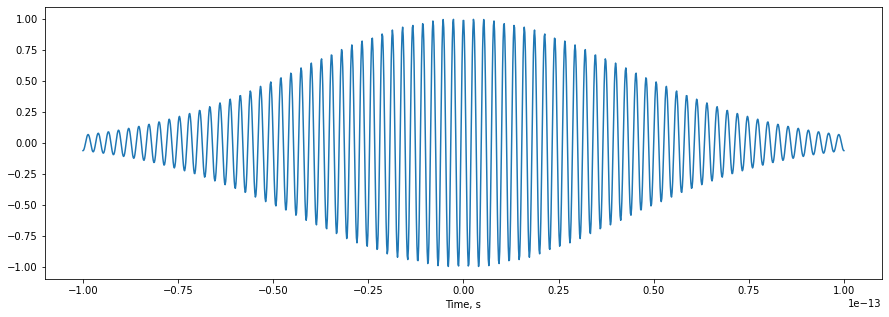

In [131]:
e_t, a_t = sim.gen_e_field(delay=0, plotting=True);

* Generate an interferogram by calling ```gen_interferogram``` method on the initialised class instance.

(1334,)
(1334,)
(1334,)


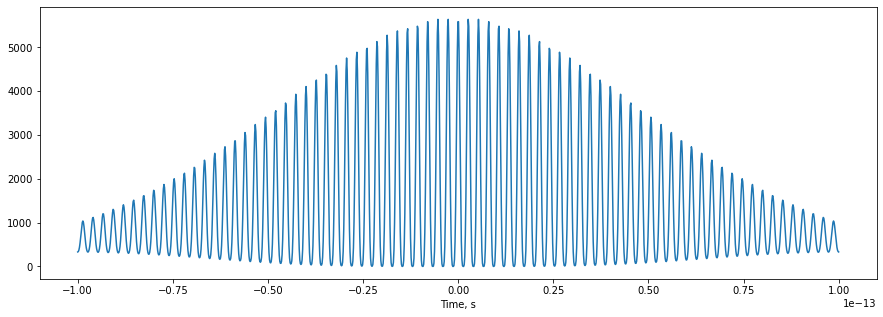

In [132]:
sim.gen_interferogram_simulation(temp_shift=0, plotting=True)

### TODO: Fit to experimental data 

## Time-frequency analysis

* Normalize  an interferogram to have 1 to 8 ratio, just as we did for experimental data.

In [133]:
sim.normalize_interferogram_simulation(normalizing_width=10e-15, t_norm_start=-1000e-15)

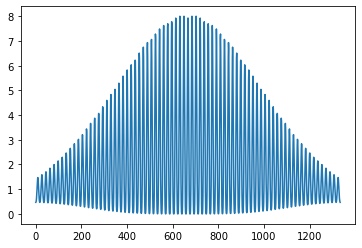

In [134]:
from matplotlib import pyplot as plt
import numpy as np

plt.plot(sim.interferogram)
plt.show()


* Simulate the g2 function analytically

##### * Compute spectrogram by calling ```compute_spectrogram```mehod on the class instance.
* Optimise the spectral resolution by varying the window size ```nperseg``` argument
* Set ```delta_f=1 / sim.delta_tau```  - should be changed in the future by moving the sim.delta_tau argument to the base class

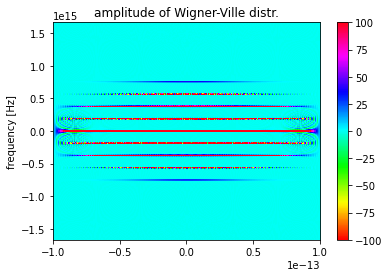

In [135]:
sim.compute_wigner_ville_distribution(sim.tau_samples, sim.interferogram, plotting=True, vmin=-100, vmax=100)

* The g2 function distribution can be generated by calling the ```gen_g2``` method on the instance of the ```Simulation``` class. As an input argument, provide the temporal samples.  

* The g2 function distribution from the simulated data can be generated by calling the ```gen_g2``` method on the instance of the ```Simulation``` class. No input arguments is needed. 

* In order to plot the experiemntal data  

## Second-order correlation function 

### Analytical computation

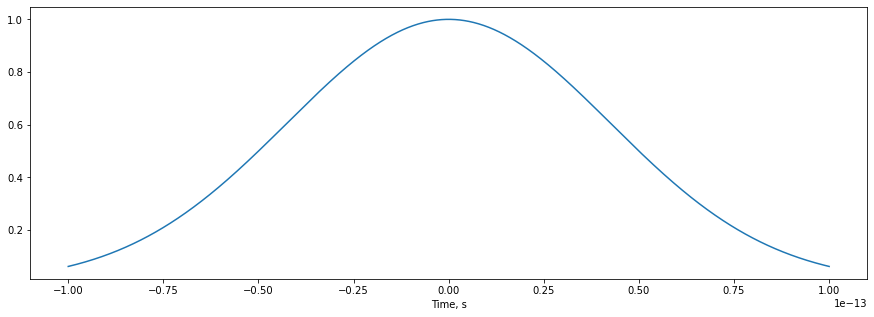

In [136]:
g2 = sim.gen_g2_analytical(plotting=True)

### TODO: Fitted g2

### By low-pass filtering 

* Compute  the g2 function by low-pass filtering simulated interferogram.

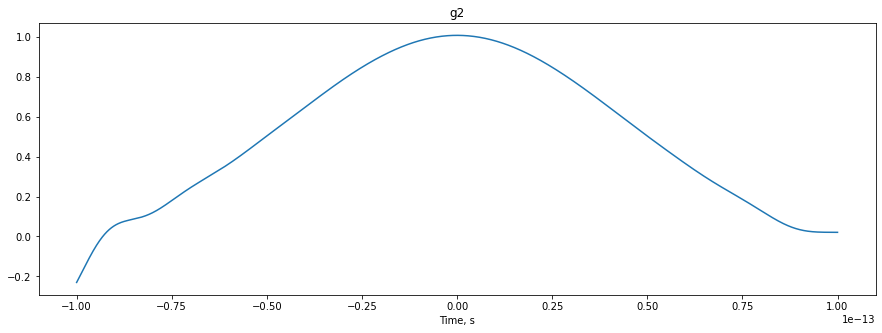

In [171]:
sim.gen_g2(filter_cutoff=50e12, filter_order=6, plotting=True)

<class 'numpy.ndarray'>


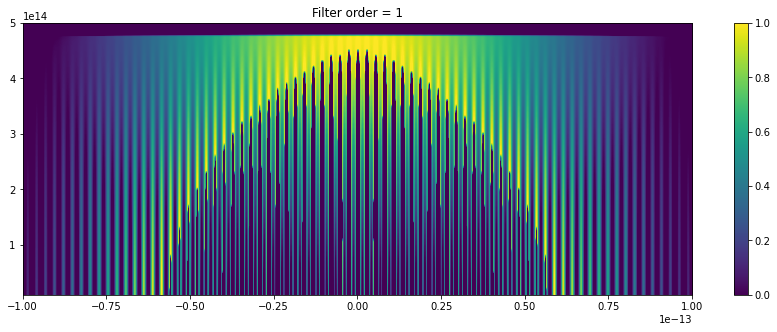

<class 'numpy.ndarray'>


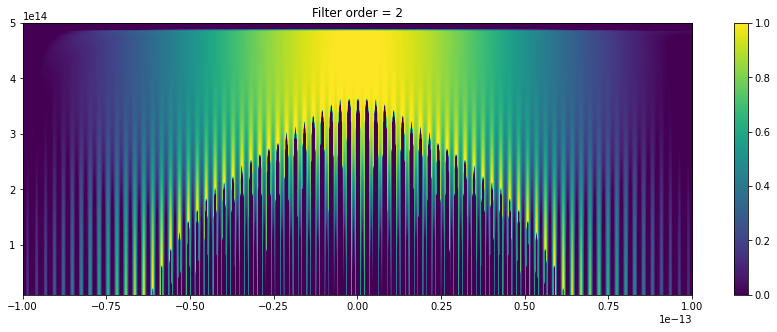

<class 'numpy.ndarray'>


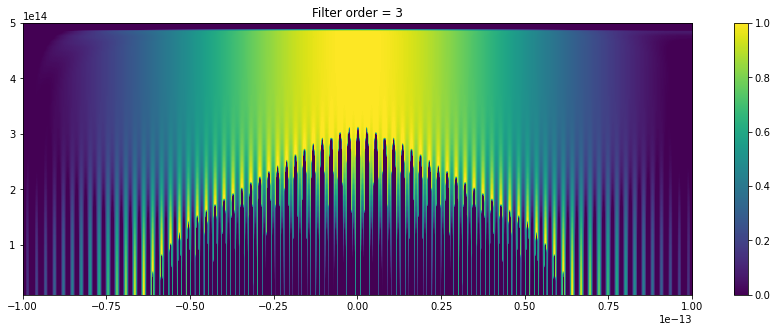

<class 'numpy.ndarray'>


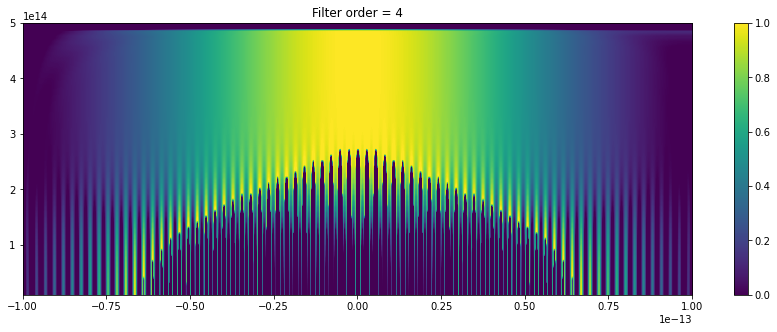

<class 'numpy.ndarray'>


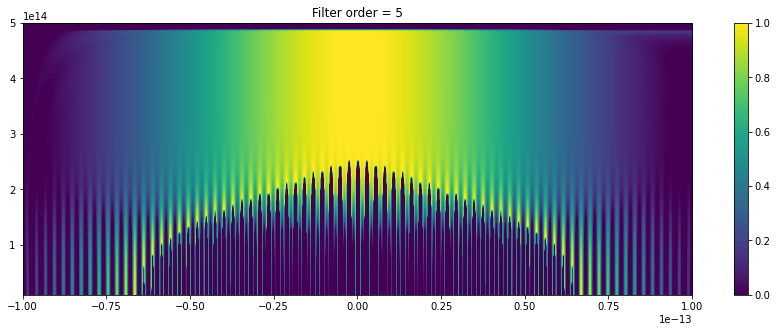

<class 'numpy.ndarray'>


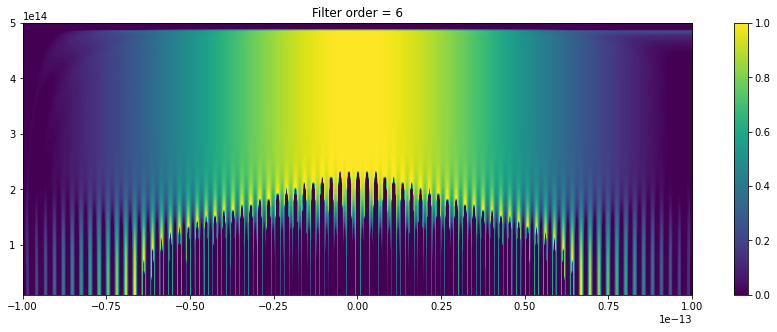

<class 'numpy.ndarray'>


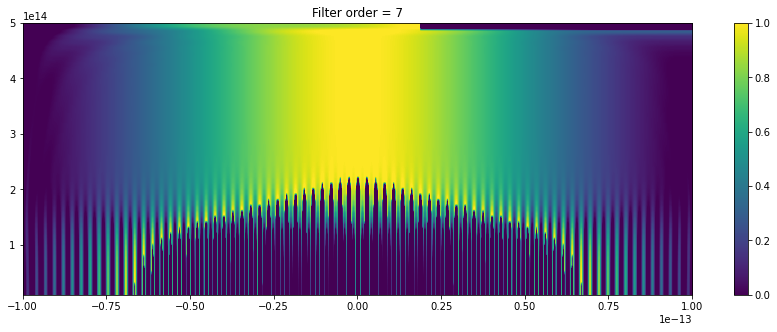

<class 'numpy.ndarray'>


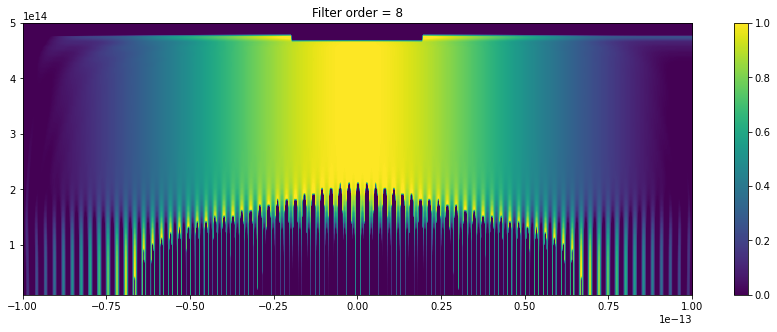

<class 'numpy.ndarray'>


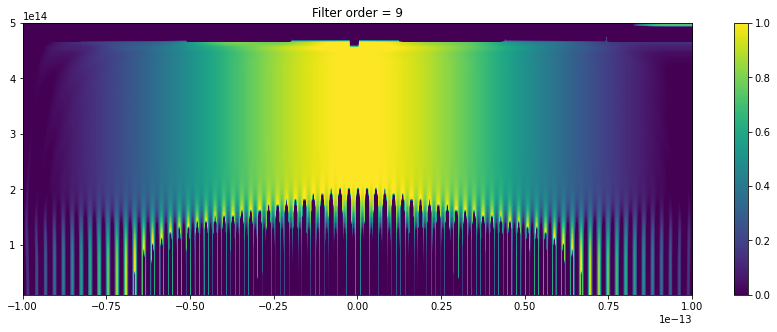

<class 'numpy.ndarray'>


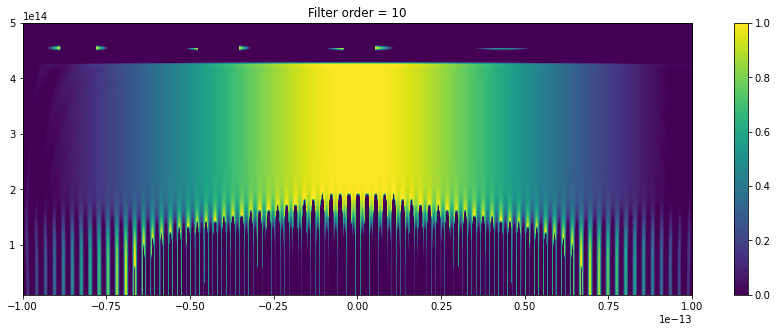

<class 'numpy.ndarray'>


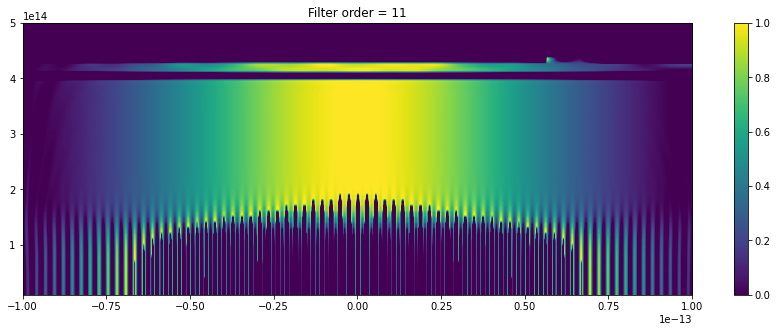

<class 'numpy.ndarray'>


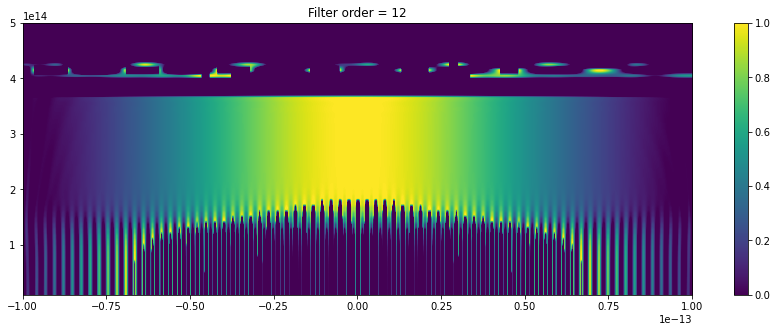

<class 'numpy.ndarray'>


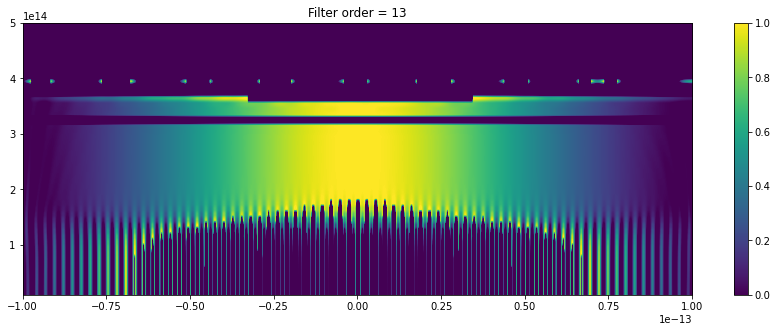

<class 'numpy.ndarray'>


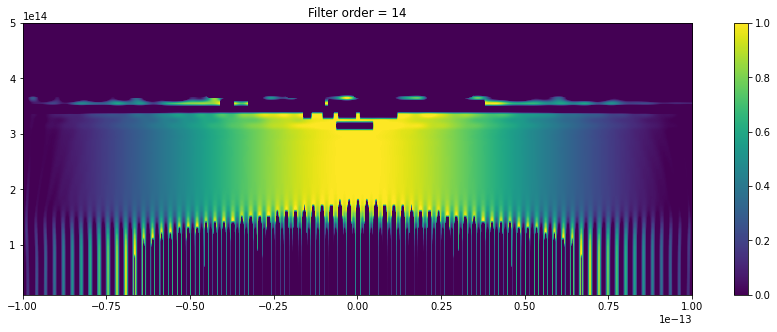

<class 'numpy.ndarray'>


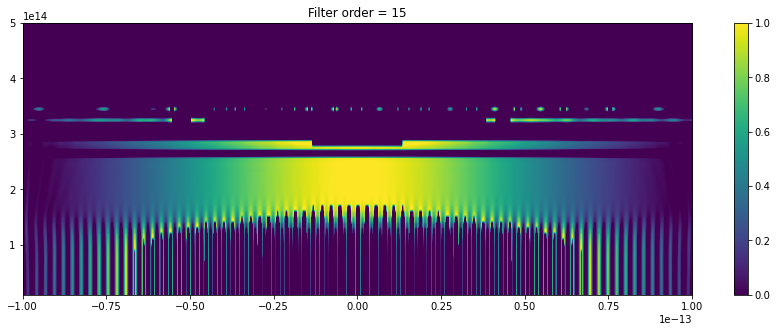

<class 'numpy.ndarray'>


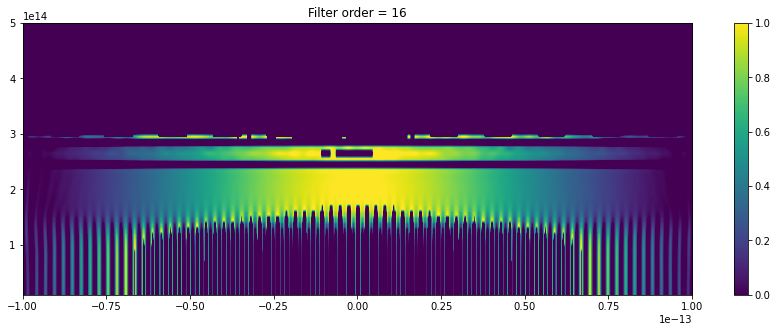

<class 'numpy.ndarray'>


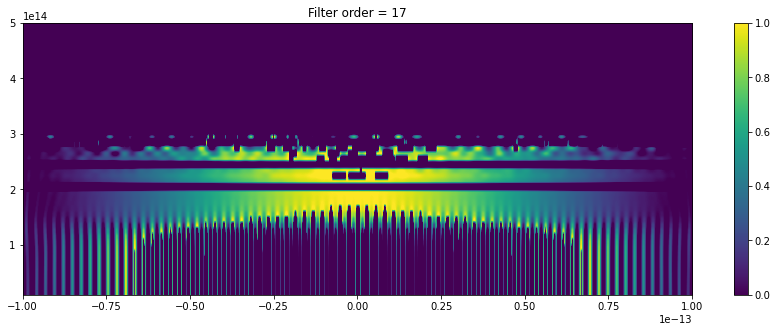

<class 'numpy.ndarray'>


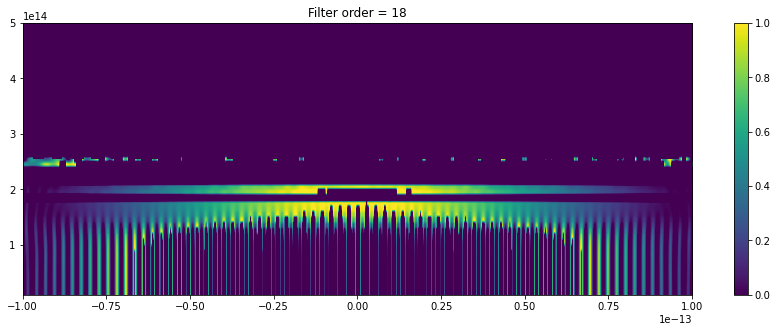

<class 'numpy.ndarray'>


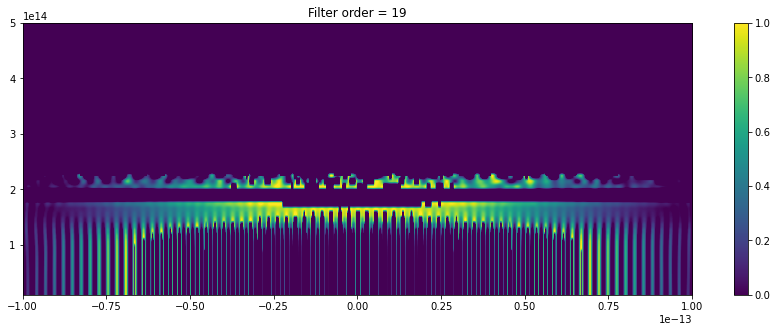

In [241]:
for fo in range(1,20,1):
    sim_g2_survey = []

    for fc in range(1,50,1):
        fc = 10e12 * fc
        #print(fc)
        #
        sim.gen_g2(filter_cutoff=fc, filter_order=fo, plotting=False)
        sim.g2[sim.g2.max()<0.999]=-1
        sim_g2_survey.append(sim.g2)
        #

    sim_g2_survey = np.array(sim_g2_survey)

    sim_g2_survey[sim_g2_survey>1.05]=-1
    sim_g2_survey[sim_g2_survey.max()<0.99]=-1

    print(type(sim_g2_survey))
    #
    fig, ax = plt.subplots(1, figsize=(15, 5))
    plt.imshow(sim_g2_survey, aspect='auto',
               cmap = plt.get_cmap("viridis"), vmin=0, vmax=1,
                  extent=(sim.tau_samples.min(), sim.tau_samples.max(),
                          fc_0 * fc_min, fc_0 * fc_max))
    plt.title("Filter order = {}".format(fo))
    plt.colorbar()
    plt.show()

    

### TODO: Fit the filter parameters  to have g2=1 

### Wiener filter 

In [138]:
# constuct Wiener filter
# ft = np.fft.rfft(intensity)[1:]
# freq = np.fft.rfftfreq(len(time_samples), time_step)[1:]

signal = sim.interferogram
print(signal.shape)
signal_exp = ifgm.interferogram
print(signal_exp.shape)
g2_analytical = sim.g2_analytical

# Wiener filter based on a signal and analytical g2
phi_xd = np.fft.ifft(np.fft.fft(signal) * np.fft.fft(g2_analytical))
phi_xx = np.fft.ifft(np.fft.fft(signal) * np.fft.fft(signal))
phi_xd_ft = np.fft.fft(phi_xd)
phi_xx_ft = np.fft.fft(phi_xx)
optimal_filter  = phi_xd_ft / phi_xx_ft

# should yield and yields g2=1
filtered_signal = np.fft.ifft(np.fft.fft(signal) * optimal_filter)

# does not yield g2=1,  - have to fit the sim. signal to the experimental  data to get the right filter first!
filtered_signal_exp = np.fft.ifft(np.fft.fft(signal_exp) * optimal_filter)

(1334,)
(1334,)


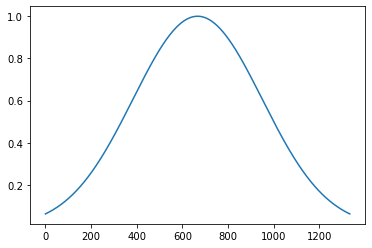

In [139]:
plt.plot(np.abs(filtered_signal))
plt.show()

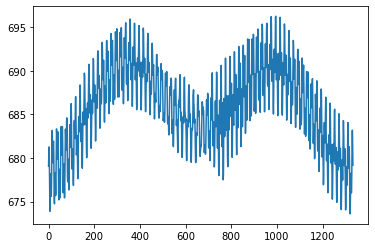

In [140]:
plt.plot(np.abs(filtered_signal_exp))